# Primal - Dual Algorithm for 2 Customer types




 ###  Code Appendix or Variable description:
     
    ###### c     = total inventory at current time.
    ###### c0    = Inventory before or at start of booking period
    ###### T     = total booking time.
    ###### t     = time instances to divide booking time.
    ###### xt    = Unit of Booking time T one instance has.
    ###### K     = Total subphases in phase 1 (K x t = P1)
    ###### ki    = 1 Subphase in Phase 1 or 1 element in K range
    ###### P1    = total booking time of phase 1.
    ###### P2    = total percbooking time of phase 2,  P1+P2 = T, a phase can have many subphases.
    ###### p     = price list for type 1 (Reserve Custopmers), initially created after inputs of Highest and Lowest price taken form user.
    ###### p2     = price list for type 2 (Preemptive Custopmers), initially created after inputs of Highest and Lowest price taken form user.
    ###### df    = data frame for demand generated in 1 subphase in Exploration (Phase 1).
    ###### df_1    = data frame for complete Exploration (Phase 1).
    ###### pt    = price for a particular instance, pt is in range p.
    ###### z     = dual variable at beginning, can be zero at 1st instance.
    ###### z_opt = z*, optimal dual variable for both types (Reserved and Preemptive) customers.
    ###### p_opt_1 = p*, optimal price for 1st type (Reserve Customers) in Exploration.
    ###### p_opt_2 = p*, optimal price for 2nd type (Preemptive Customers) in Exploration.
    ###### delta = (δ) parameter used in exploration for narrowing price intervals near optimal price.
    ###### p_low = lower price limit when we narrow price intervals towards optimal price.
    ###### p_upp = upper price limit when we narrow price intervals towards optimal price.
    ###### num_steps = Total number of Price points wanted
    ###### customers_per_price = number of customers approaching per price
    ###### total_customers = 2*customers_per_price*num_steps (total price points), total customers approaching for 1 subphase.
    ###### customer_data = List to store customer data
    ###### demand_probability = demand function for a particular instance, probability of buying at price pt and instance t. 
    ###### demand_history = List to store demand and price relation data.

    ****** In all variables names, the sufix _1 or _2 represent the type of the customer, type _1 is Reserved Customers and type _2 is Preemptive Customers.  

## Importing Libraries:

In [1]:
# importing libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import math
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

ModuleNotFoundError: No module named 'matplotlib'

# Phase 1 - Exploration Start:

Below defined are functions used in phase 1's main function i.e. Exploration function, which is defined below these functions.

Functions are defined according to sequence in algorithm flow in phase 1.

### Demand Function: 
Returns base probability of purchase:

In [ ]:
#################################################################################################################################################################################################
#""" Demand Function - Returns the base probability of purchase at price p """

# (Logistic) - Demand function - type  1: Reserve
def logistic_demand_reserved(pt, p, p0=0,L=1, k=0.005 ):
        p0=(p.min()+p.max())/2
        return L / (1 + np.exp(k * (pt - p0)))   


# (Logistic) - Demand function - type  2: Preemtive
def logistic_demand_preemptive(pt, p, p0=0,L=1, k=0.04 ):
        p0=(p.min()+p.max())/2
        return L / (1 + np.exp(k * (pt - p0)))   



# (Poisson method) - Demand function for Simulation for Exploration (P1)

# Poisson-style Demand for Reserved
def poisson_demand_reserved(pt,  base_lambda=8.0, price_sensitivity=0.0025):
    lambda_ = base_lambda * np.exp(-price_sensitivity * pt)
    prob = 1 - np.exp(-lambda_)
    return np.clip(prob, 0.01, 0.99)

# Poisson-style Demand for Preemptive
def poisson_demand_preemptive(pt, base_lambda=10.0, price_sensitivity=0.009):
    lambda_ = base_lambda * np.exp(-price_sensitivity * pt)
    prob = 1 - np.exp(-lambda_)
    return np.clip(prob, 0.01, 0.99)




### Demand Probability function:     
Computes probability of buying from demand generated

In [ ]:
#####################################################################################################################################################################################################
#""" Compute Demand Probability Function for a price pt -  Dx(p) in Paper - for Exploration (P1)"""

# Global dictionary to store demand probabilities per price
demand_probability = {}

def compute_demand_probability(df, p):
    
    """ Calculates demand probabilities from exploration data. 
    Uses 'p' list and 'pt' to access prices as per user's convention.
    Stores result in global variable `demand_probability`.
    """

    global demand_probability
    demand_probability = {}

    for pt in p:
        subset = df[df['price'] == pt]
        if not subset.empty:
            demand_prob = subset['buy'].sum() / subset['buy'].count()
            demand_probability[pt] = demand_prob
        else:
            demand_probability[pt] = 0.0  # fallback if no data at this price

    # print("*** Demand Probabilities ***")
    for pt in p:
        print(f"Price: {pt:.2f}, Demand Probability: {demand_probability[pt]:.2f}")
    
    return demand_probability



### Revenue Calculation:
 (Normal ***without*** considering ***z_opt***, unit value of inventiory)

In [ ]:
################################################################################################################################################################################################
#""" Compute Revenue for each price for Exploration (P1) """

def calculate_revenue(df):

    """
    Calculates total revenue from exploration sales data
    :param df: DataFrame containing sales data (must have 'price' and 'buy' columns)
    :return: Total revenue, Revenue per price point dictionary
    """
    
    # Calculate revenue for each transaction
    df['revenue'] = df['price'] * df['buy']
    
    # Calculate total revenue
    total_revenue = df['revenue'].sum()
    
    # Calculate revenue per price point
    revenue_per_price = df.groupby('price')['revenue'].sum().to_dict()
    
    return total_revenue, revenue_per_price

### Dual Variabble: '***z_opt***'  calculation function:
Gives unit value of inventory, after taking into consideration Inventory change, time, prices and demand.

In [ ]:
#######################################################################################################################################################################################################
# # Dual optimization: Find optimal value i.e. - z_opt in code and z* in paper for Exploration (P1)

"""For bounds from 0 to maximum price"""
""" Minimize_scalar used to optimize"""

def dual_objective(z, demand_probability, p, c):
    
    # Finding order of magnitude of optimal price respective to the customer
    # Order of Magnitude is needed as the dual variable z* value comes in very small number e.g. 0.00000..irrespective of price e.g. 100 range or 1000 or 10,000, etc..., 
    # and to make sense of dual variable we multiply it with magnitude of optimal price so it's with respect to optimal price and makes sense.
    magnitude_p_opt = len(str(int(abs(min(p)))))
    magnitude_order_p_opt=(10**(magnitude_p_opt-1))

    def objective(z):
        return max((pt - z) * demand_probability[pt] for pt in p) + z * c
    z_opt = minimize_scalar(objective, bounds=(0, max(p)), method='bounded')
    return z+((z_opt.x) *(10**5)*(magnitude_order_p_opt))



### Optimal Price calculation function:
Calculates optimal price, takes into consideration of unit value of inventory and price at which highest demand is generated.

Adjusted Profit Revenue: (price - z_opt) x demand

here, z_opt is unit value of inventory 

and demand is probability of buying into customers approached or simply units sold at that price.

In [ ]:
#######################################################################################################################################################################################################
# Calculate and find optimal price - p* in paper for Exploration (P1)

def exploration_optimal_price (z_opt, demand_probability, p,customers_per_price):

    """
    Finds optimal price p* that maximizes (p - z*) * D_prob.(pt) (demand_probability[pt])
    where D_prob.(pt) is the empirical demand probability at price p.
    
    Parameters:
    - z_opt: optimal dual value (float)
    - demand_probability: dict mapping price -> demand probability
    - p: list or array of price points

    Returns:
    - p_opt: optimal price
    """

    optimal_price = None
    best_value = float('-inf')

    for pt in p:
        demand = demand_probability.get(pt, 0)
        value = (pt - float(z_opt)) * demand
        if value > best_value:
            best_value = value
            optimal_price = pt

    #print(f"*** Optimal Price Calculation ***")
    print(f"Optimal Price (p*): {optimal_price:.2f},\nFor Highest Revenue Value: {best_value*customers_per_price:.2f}")
    return optimal_price



### Narrow Price Interval Calculation function:
Narrows down price interval towards optimal price.

In [ ]:
##########################################################################################################################################################################################
# Narrow Price Interval Function for Exploration

def narrow_price_interval(p_opt, n, k, epsilon, p, num_steps, global_min,global_max ):
    
    """
    Narrows the price interval around the estimated optimal price using 
    the theoretical shrinking factor from the paper.

    Parameters:
    - p_opt: Optimal price estimate from current subphase
    - n: Number of total customers observed so far
    - k: ki = Current subphase index (starting from 0)
    - epsilon: Small constant (e.g., 0.01)
    - p: Current price list (to extract full range)
    - num_steps: Number of price points to generate in next subphase

    Returns:
    - (p_low, p_upp, new_price_list): narrowed interval and refined grid
    """

    # Finding order of magnitude of optimal price respective to the customer
    # Order of Magnitude is needed as the delta value comes to in very small number e.g. 0.00000.... irrespective of price e.g. 100 range or 1000 or 10,000, etc..., 
    # and to make sense of delta we multiply it with order of magnitude of optimal price so it's with respect to optimal price and makes sense. 
    
    magnitude_p_opt = len(str(int(abs(min(p)))))
    magnitude_order_p_opt=(10**(magnitude_p_opt-1))
    
    
    # Compute interval shrinking factor - parameter δ - Delta
    log_n = np.log(n) 
    delta = ((n ** ((-0.25) * (1 - ((3 / 5) ** k)))) * (log_n ** (-3 * epsilon)))  * (magnitude_order_p_opt)


    # Generate new interval around p_opt
    p_low = max(min(p), p_opt - delta)
    p_upp = min(max(p), p_opt + delta)

    # Ensure Interval does not Collapse*
    if p_low >= p_upp:
        # Fallback: Use 10% of current interval width
        width = (max(p) - min(p)) * 0.1
        p_low = max(global_min, p_opt - width)
        p_upp = min(global_max, p_opt + width)

    # New refined price grid
    new_price_list = np.linspace(p_low, p_upp, num_steps)

    #print(f"*** Subphase {k+1} Price Interval Update ***")
    print(f"delta: {delta:.5f}")
    print(f"New Interval: [{p_low:.2f}, {p_upp:.2f}]")
    #print(f"New Price List: {new_price_list}")
    #or
    print(f"New Price List: {[int(x) for x in new_price_list]}")


    return p_low, p_upp, new_price_list


### Plotting function for Phase 1 i.e. Exploration: ***Price vs Demand***
Plots - Price vs Demand.

For both customer types. 

In [ ]:
#############################################################################################################################################################################################
# Plot Exploration demand curve

def plot_exploration_demand_curves(history):
    
    plt.figure(figsize=(14, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(history)))  # Color gradient

    # Type 1 Plot
    plt.subplot(1, 2, 1)
    for i, data in enumerate(history):
        plt.plot(data['type1'][0], data['type1'][1],
                'o-', color=colors[i],
                label=f'Subphase {data["subphase"]}',
                alpha=0.8)
    plt.title('Exploration: Reserved Customers (Type 1)\nPrice vs. Demand Probability')
    plt.xlabel('Price ($)')
    plt.ylabel('Demand')
    plt.grid(alpha=0.2)
    plt.legend()

    # Type 2 Plot
    plt.subplot(1, 2, 2)
    for i, data in enumerate(history):
        plt.plot(data['type2'][0], data['type2'][1],
                's--', color=colors[i],
                label=f'Subphase {data["subphase"]}',
                alpha=0.8)
    plt.title('Exploration: Preemptive Customers (Type 2)\nPrice vs. Demand Probability')
    plt.xlabel('Price ($)')
    plt.ylabel('Demand')
    plt.grid(alpha=0.2)
    plt.legend()

    plt.tight_layout()
    plt.show()



### Price List Generation function:
Generates price list according to user input.

In [ ]:
#################################################################################################################################################################################
# Generate price ranges step wise as mentioned by user

# shared object just for num_steps: number of price points
# made this as num_steps is going to be used in two different functions
context = {}

# Generate price ranges step wise as mentioned by user
def generate_price_list_1(num_steps):
    min_price_1 = float(3000)  #float(input("Enter the minimum price: "))
    max_price_1 = float(7000)  #float(input("Enter the maximum price: "))
    num_steps = num_steps
    context['max_price_1'] = max_price_1
    context['min_price_1'] = min_price_1
    price_list = (np.linspace(min_price_1, max_price_1, num_steps))
    return price_list


# Generate price ranges step wise as mentioned by user
def generate_price_list_2(num_steps):
    min_price_2 = float(1000)  #float(input("Enter the minimum price: "))
    max_price_2 = float(5000)  #float(input("Enter the maximum price: "))
    num_steps = num_steps
    context['max_price_2'] = max_price_2
    context['min_price_2'] = min_price_2
    price_list = (np.linspace(min_price_2, max_price_2, num_steps))
    return price_list



### Time allocation function for Phase 1  i.e. Exploration: 
Allocates time to phase 1 from total booking time peroid T.

In [ ]:
##################################################################################################################################################################################
# Calculate how much unit of time is allocated to Phase 1 

def phase_one_days_calc(num_steps,xt,T):
    xp=int(33)    #int(input("Enter % of Phase 1, between 0 to 100:"))
    num_steps = num_steps
    xt=xt
    T=T
    if (T*(xp/100)) % (num_steps*xt) == 0:
        phase = T*xp
    else:
        phase = (T*(xp/100)) - ((T*(xp/100))% (num_steps*xt))
    return phase


### Exploration Function:
Conducts Phase 1 of Primal - Dual algorithm.

In [ ]:
####################################################################################################################################################################################################
# Exploration (Phase - 1) Function:

def exploration(c,c0, T, unit_T, t, xt, ki, K, P1, p, p2, z, customers_per_price,total_customers, num_steps, demand_history, customer_id,T0):
    
    """ Exploration funciton for performing Phase 1 of Primal - Dual Algorithm """

    # list to store customer data for a subphase in exploration
    customer_data = []

    # Serial number given tocustomer as they aproach
    if ki==0:
        customer_id = 1
    else:
        customer_id = customer_id

    for _ in range(total_customers):
        # Randomly assign customer type: 1 (Reserved) or 2 (Preemptive)
        #currently assigned 50% - 50% for both categories
        cust_type = np.random.choice([1, 2], p=[0.5, 0.5])  # 50% Reserved, 50% Preemptive)

        # Picks price pt **randomly** from appropriate price list p or p2
        # Add noise to demand probability
        # buying probability set according to Logistic funciton 
        if cust_type == 1:
            pt = np.random.choice(p)
            base_prob = logistic_demand_reserved(pt, p)
            noise = np.random.normal(0, 0.0258)  # More stable behavior
        else:
            pt = np.random.choice(p2)
            base_prob = logistic_demand_preemptive(pt, p2)
            noise = np.random.normal(0, 0.258)  # More volatile behavior


        # Use either of two If Else statement pair, Upper^^^ is for Logistic, Lower vvv is for Poisson.


        # Picks price pt **randomly** from appropriate price list p or p2
        # Add noise to demand probability
        # buying probability set according to Poisson Distribution
          
        # if cust_type == 1:
        #     pt = np.random.choice(p)
        #     base_prob = poisson_demand_reserved(pt)
        #     noise = np.random.normal(0, 0.025)
        # else:
        #     pt = np.random.choice(p2)
        #     base_prob = poisson_demand_preemptive(pt)
        #     noise = np.random.normal(0, 0.15)

        
        prob = np.clip(base_prob + noise, 0.01, 0.99)
        buy = int(np.random.rand() < prob)

        # Store data: [customer_id, price offered, bought?, customer_type]
        customer_data.append([customer_id, pt, buy, cust_type])
        customer_id += 1


    # Create DataFrame including customer_type
    df = pd.DataFrame(customer_data, columns=["customer_id", "price", "buy", "customer_type"])
    # price rounded to two places
    df["price"] = df["price"].round(2)
    #print(df.head())
    print(df)
    


    # Calculate total units sold from both types
    units_sold = df['buy'].sum()
    c = float(c) - units_sold
    


    # Compute empirical demand probability separately per customer type
    print("\n* Demand Prob. - Type 1: Reserved *")
    demand_probability_1 = compute_demand_probability(df[df['customer_type'] == 1], p)

    print("\n* Demand Prob. - Type 2: Preemtive *")
    demand_probability_2 = compute_demand_probability(df[df['customer_type'] == 2], p2)



    # Revenue calculation separately per customer type    
    total_revenue_1, revenue_per_price_1 = calculate_revenue(df[df['customer_type'] == 1])
    total_revenue_2, revenue_per_price_2 = calculate_revenue(df[df['customer_type'] == 2])
    total_revenue = total_revenue_1 + total_revenue_2

    print("\n* Revenue Calculation - Customer Type 1 (Reserve) *")
    for pt in p:
        print(f"Price: {pt:.2f}, Revenue: {revenue_per_price_1.get(pt, 0):.2f}")
    print("Total Revenue- type 1:",total_revenue_1)
    print("\n* Revenue Calculation - Customer Type 2 (Preemptive) *")
    for pt in p2:
        print(f"Price: {pt:.2f}, Revenue: {revenue_per_price_2.get(pt, 0):.2f}")
    print("Total Revenue- type 2:",total_revenue_2)
    print(f"\nTotal Revenue (Both Types): {total_revenue:.2f}")



    # Dual optimization - now needs to consider both customer types separately or combined
    # You can do separate dual variable calculations or a weighted combined one.
    # For simplicity, run separately and sum the dual objectives or take weighted average
    z_opt_1 = dual_objective(float(z), demand_probability_1, p, float(c))
    z_opt_2 = dual_objective(float(z), demand_probability_2, p2, float(c))
    # Combine dual variables with weighted average by revenue or units sold; here equal weight:
    z_opt = (z_opt_1 + z_opt_2) / 2
    z_opt = round(z_opt, 2) # rounding to two places
    print(f"\n*** Optimal dual variable (z*) combined: {z_opt:.2f}")
    



    # Optimal price calculation separately
    print("\n* Type 1: Reserved *")
    p_opt_1 = exploration_optimal_price(z_opt_1, demand_probability_1, p, customers_per_price)
    p_opt_1 = round(p_opt_1, 2) # rounding price to two places

    print("\n* Type 2: Preemtive *")
    p_opt_2 = exploration_optimal_price(z_opt_2, demand_probability_2, p2, customers_per_price)
    p_opt_2 = round(p_opt_2, 2) # rounding price to two places




    # Narrow price intervals separately
    print("\n\n* Narrowed Price Interval - Type 1: Reserved *")
    p_low_1, p_upp_1, new_price_list_1 = narrow_price_interval(p_opt_1, 
                                                               n=len(df[df['customer_type'] == 1]),
                                                                k=ki, epsilon=0.01, p=p, num_steps=num_steps,
                                                                global_min=context['min_price_1'], 
                                                                global_max=context['max_price_1'])
    # rounding to two places
    p_low_1, p_upp_1, new_price_list_1 = round(p_low_1, 2), round(p_upp_1, 2), np.array([round(p, 2) for p in new_price_list_1])



    print("\n* Narrowed Price Interval - Type 2: Preemtive *")
    p_low_2, p_upp_2, new_price_list_2 = narrow_price_interval(p_opt_2, 
                                                               n=len(df[df['customer_type'] == 2]),
                                                                k=ki, epsilon=0.01, p=p2, num_steps=num_steps,
                                                                global_min=context['min_price_2'], 
                                                                global_max=context['max_price_2'])
    # rounding to two places
    p_low_2, p_upp_2, new_price_list_2 = round(p_low_2, 2), round(p_upp_2, 2), np.array([round(p, 2) for p in new_price_list_2])


    # Update T
    T = T - (num_steps * xt)
    print("\nRemaining booking period 'T' = ", T, unit_T, "\n\n------------------------------------------------------------")


    # Store complete subphase data (appended at each call)
    demand_history.append({
        'subphase': ki + 1,
        'type1': (p.copy(), list(demand_probability_1.values())),
        'type2': (p2.copy(), list(demand_probability_2.values()))
    })



    if ki == K - 1:
        print("\n\n------------------------------------------------------------------------")
        print("\n***** Phase 1 - Exploration finished *****\n")
        print('Final values after Exploration:\n')
        print(f"Optimal dual variable (z*) combined: {z_opt:.2f}")
        print(f"Optimal Prices: p_opt_1* = {p_opt_1:.2f}, p_opt_2* = {p_opt_2:.2f}")
        print(f"Percentage of inventory used: {(((c0-c)/c0)*100):.2f}%")
        print(f"Remaining inventory after sales: {c}, out of total inventory {c0} units.")
        print(f"Percentage of inventory remaining: {((c/c0)*100):.2f}%")
        print("Remaining Booking Period T = ", T, "out of total of", T0,unit_T)
        print("\n-----------------------------------------------------------------------------\n\n")
        plot_exploration_demand_curves(demand_history)
        print("----------------------------------------------------------------------------------")


    return df, z_opt, (p_opt_1, p_opt_2), c, T, (p_low_1, p_low_2), (p_upp_1, p_upp_2), (new_price_list_1, new_price_list_2), total_revenue, customer_id


### User Input:
Takes input from user about basic given data like: Total inventory c, Total Booking peroid T, etc.

In [ ]:
####################################################################################################################################################################################
# Take input from the user
# or
# Give given data to code basically

c     = float(10000) #float(input("Total Inventory 'c' :   "))
T     = float(100)  #float(input("Total booking peroid 'T' :  "))
unit_T= "days" #input("Enter unit of booking peroid (Usually days):")
t     = float(100)  #float(input("Instances 't' to divide Time peroid T into :  "))
xt    = T/t
num_steps = int(5)   #int(input("Enter how many price points you want: "))
p     = generate_price_list_1(num_steps)
p_1_initial = p
p2    = generate_price_list_2(num_steps)
p_2_initial = p2
P1    = phase_one_days_calc(num_steps,xt,T)   
K     = int (P1/(num_steps*xt))
z     = 00   #input("Enter imitial value of 1 unit of inventory (Can be zero): ")
customers_per_price = 100    #int(input("Enter number of customer approaching per price (e.g. 10):"))
total_customers = 2*customers_per_price*num_steps   #2 for 2 customer types 
c0    = c   # Initial Inventory declared before or at start of booking period, variable defined as original variable c is changing as we run code
T0    = T   # Booking peroid set by user, again variable made as T original variable is going to change while running algorithm

customer_data = [] # list to store customer data into data frame df_1 from exploration phase
df_1 = pd.DataFrame(customer_data, columns=["customer_id", "price", "buy", "customer_type"]) # dataframe to store Phase 1 data

demand_history = [] # list to store demand values with respect to price

p_opt_type1 = [] #list for collecting optimal prices of type 1 customer
p_opt_type2 = [] #list for collecting optimal prices of type 2 customer

# Serial number given tocustomer as they aproach
customer_id = 1

print("*** USER INPUTS ***")
print("Total Inventory c:", c)
print("Total booking peroid T:", T,unit_T)
print("Total Instances t:", t)
print("1 time Instance from t i.e. xt:", xt, unit_T)
print("Generated prices for Reserved Cust (Type 1):", p)
print("Generated prices for Preemptive Cust (Type 2):", p2)
print("Total time allocated to Phase 1:",P1)
print("Total subphases 'K' in Phase 1: ",K, '\n')

*** USER INPUTS ***
Total Inventory c: 10000.0
Total booking peroid T: 100.0 days
Total Instances t: 100.0
1 time Instance from t i.e. xt: 1.0 days
Generated prices for Reserved Cust (Type 1): [3000. 4000. 5000. 6000. 7000.]
Generated prices for Preemptive Cust (Type 2): [1000. 2000. 3000. 4000. 5000.]
Total time allocated to Phase 1: 30.0
Total subphases 'K' in Phase 1:  6 



### Main Loop 1: Conduct Exploration
This loop runs until all subphases in phase 1 are completed.

It calls exploration funciton.

There are two main loops, first is for conducting phase 1 i.e. exploration and second is for conducting phase 2 i.e. exploitation.

Loop for exploitation i.e. phase 2 is way below in phase 2 part of notebook after exploitation function.




 ***Expoloration Start - Detailed Data:***

 Phase 1 (P1), Subphase (ki):  1 

     customer_id   price  buy  customer_type
0              1  4000.0    1              1
1              2  4000.0    1              1
2              3  1000.0    1              2
3              4  4000.0    1              1
4              5  7000.0    0              1
..           ...     ...  ...            ...
995          996  4000.0    1              1
996          997  1000.0    1              2
997          998  5000.0    0              2
998          999  4000.0    0              2
999         1000  3000.0    0              2

[1000 rows x 4 columns]

* Demand Prob. - Type 1: Reserved *
Price: 3000.00, Demand Probability: 0.97
Price: 4000.00, Demand Probability: 0.99
Price: 5000.00, Demand Probability: 0.48
Price: 6000.00, Demand Probability: 0.01
Price: 7000.00, Demand Probability: 0.01

* Demand Prob. - Type 2: Preemtive *
Price: 1000.00, Demand Probability: 0.91
Price: 2000.00, Demand Probability

C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2180988554.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['revenue'] = df['price'] * df['buy']
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2180988554.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['revenue'] = df['price'] * df['buy']
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\27007326.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longe

     customer_id    price  buy  customer_type
0           3001  3141.27    0              1
1           3002  2094.13    0              2
2           3003  2094.13    0              2
3           3004  3404.91    0              1
4           3005  1490.30    1              2
..           ...      ...  ...            ...
995         3996  3317.03    0              1
996         3997  1490.30    1              2
997         3998  1641.26    1              2
998         3999  3404.91    0              1
999         4000  1490.30    1              2

[1000 rows x 4 columns]

* Demand Prob. - Type 1: Reserved *
Price: 3053.39, Demand Probability: 0.71
Price: 3141.27, Demand Probability: 0.67
Price: 3229.15, Demand Probability: 0.54
Price: 3317.03, Demand Probability: 0.40
Price: 3404.91, Demand Probability: 0.25

* Demand Prob. - Type 2: Preemtive *
Price: 1490.30, Demand Probability: 0.90
Price: 1641.26, Demand Probability: 0.84
Price: 1792.22, Demand Probability: 0.47
Price: 1943.18, Dema

C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2180988554.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['revenue'] = df['price'] * df['buy']
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2180988554.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['revenue'] = df['price'] * df['buy']
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2180988554.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

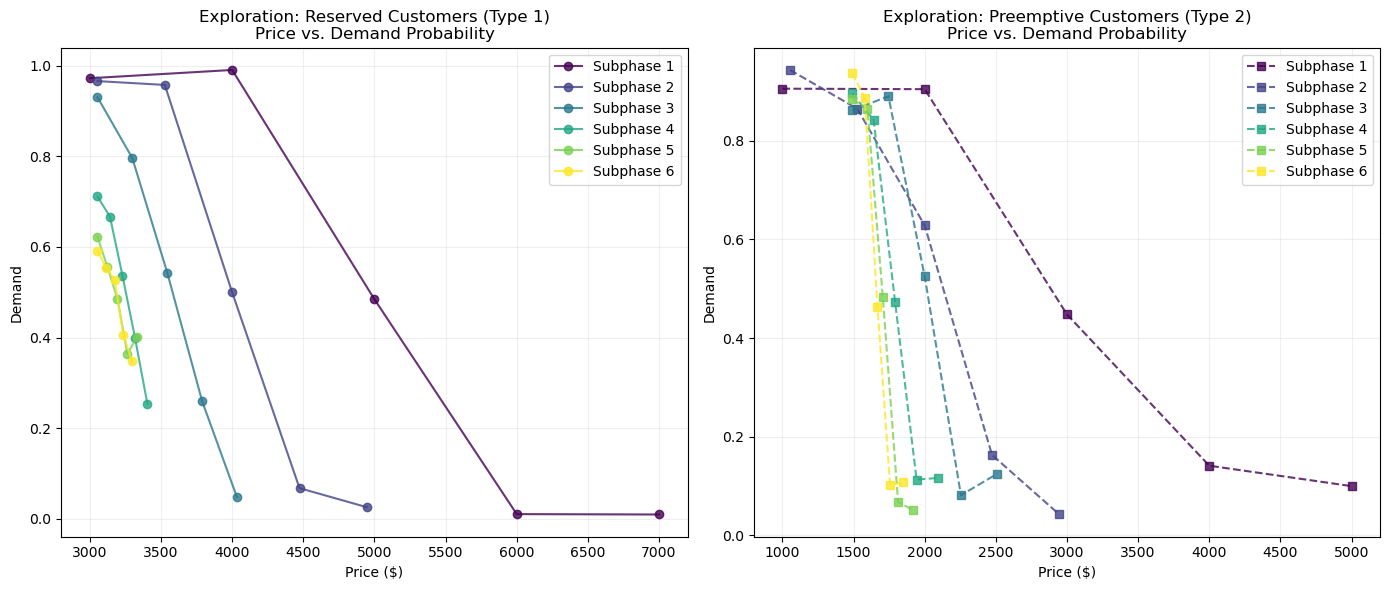

----------------------------------------------------------------------------------
Data appended and saved to all_output.csv


In [ ]:
########################################################################################################################################################################
# Conduct Phase 1   i.e.  ***Exploration***: Call the function with user inputs as given above
# Or
# Phase 1 - Loop

print("\n","***Expoloration Start - Detailed Data:***")
normal_revenue = 0

for ki in range(K): 

    if c>0: # Inventory should exist  before sale
    
        print("\n","Phase 1 (P1), Subphase (ki): ", ki+1,"\n")
        
        df, z_opt, p_opt_tuple, c, T, p_low_tuple, p_upp_tuple, updated_p_tuple, total_revenue, customer_id = exploration(c, c0,T, unit_T, t, xt, 
                                                                                                             ki, K, P1, p, p2, z, 
                                                                                                             customers_per_price,
                                                                                                             total_customers, 
                                                                                                             num_steps, demand_history, 
                                                                                                             customer_id,T0)
        
        
        # Dataframe update for exploration - Phase 1
        df_1 = pd.concat([df_1, df], ignore_index=True)
        df_1["price"] = df_1["price"].round(2) # rounding price 


        # Update price lists for next iteration
        p = updated_p_tuple[0]
        p2 = updated_p_tuple[1]

        # Seprating and storing Optimal prices in a list
        p_opt_type1.append(p_opt_tuple[0]) 
        p_opt_type2.append(p_opt_tuple[1]) 
        
    else:
        print("***NOT SUFFICIENT INVENTORY***")



# Save the Phase 1 dataframe to a CSV file
df_1.to_csv("all_output.csv", index=False)
print("Data appended and saved to all_output.csv")


# Seprate Data frames for different customer types for phase 1
df_1_type_1 = df_1[df_1['customer_type'] == 1].copy()
df_1_type_2 = df_1[df_1['customer_type'] == 2].copy()

############################################################################################################################################################################


#
#
#
# Phase 2: Exploitation 



#
#
### Demand Estimation fucntion:

Estimates the demand for input price to function, used in exploitation function to compare demand and remaining inventory.

Exploitation function is next after this.

Method used: ***Random forests***.

Random forests can estimate demand for a price even with unknown relationship in variables.

Known relationships example is Linear, polynomial, logistic, etc.

In [ ]:
##################################################################################################################################################################################
# Calculate buying probability based on demand generated in exploration 

def random_forest_buying_probability(df, price_value):
    """
    Trains a Random Forest classifier and predicts buying probability for a given price.
    Prints model accuracy on training data.

    Parameters:
    df (DataFrame): Filtered DataFrame for customer_type == 1
    price_value (int or float): Target price for prediction

    Returns:
    float: Predicted probability of buying
    """
    df_clean = df.copy()
    X = df_clean[['price']]
    y = df_clean['buy'].astype(int)

    # Split your data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,                     # 5-fold cross-validation
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Evaluate accuracy on test set
    test_predictions = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_predictions)
    # print(f"Tuned Random Forest test accuracy: {round(test_acc, 2)}")
    # print("Best parameters found:", grid_search.best_params_)

    # Predict probability for input price
    predicted_prob = best_model.predict_proba([[price_value]])[0][1]
    return round(predicted_prob, 2)



### Exploitation function:
Conducts Phase 2 i.e. exploitation of Primal dual algorithm.

In [ ]:
##################################################################################################################################################################################
# Exploitation Function:

def exploitation(c,T, p_opt_1, p_opt_2, z_opt,p,p2, customer_id, xt, p_1_initial, p_2_initial,T0, unit_T, df_1_type_1, df_1_type_2):

    # list to store customer data for a subphase in exploration
    customer_data = []
    # Serial number given tocustomer as they aproach
    customer_id = customer_id

    demand_estimate_1 = (T/xt)*random_forest_buying_probability(df_1_type_1, p_opt_1)
    demand_estimate_2 = (T/xt)*random_forest_buying_probability(df_1_type_2, p_opt_2)

    total_estimated_demand = demand_estimate_1 + demand_estimate_2

    # Tells user in Output, exploitation for what time is carried out of total time peroid
    print ("\n#############################################################################################")
    print ("T th Iteration running in Exploitation:", T, unit_T, " out of ",T0, unit_T,"remaining.")

    ###############################
    # Case 1 - Sufficient Inventory 
    if total_estimated_demand > c:
        p_opt_1 = p_opt_1
        p_opt_2 = p_opt_2
             
        for _ in range(2*customers_per_price):
            # Randomly assign customer type: 1 (Reserved) or 2 (Preemptive)
            cust_type = np.random.choice([1, 2], p=[0.5, 0.5])  # 50% Reserved, 50% Preemptive)

            # buying probability set according to Logistic funciton 
            if cust_type == 1:
                base_prob = logistic_demand_reserved(p_opt_1, p_1_initial)
                noise = np.random.normal(0, 0.0258)  # More stable behavior
                p_opt = p_opt_1
            else:
                base_prob = logistic_demand_preemptive(p_opt_2, p_2_initial)
                noise = np.random.normal(0, 0.258)  # More volatile behavior
                p_opt = p_opt_2
            
            prob = np.clip(base_prob + noise, 0.01, 0.99)
            buy = int(np.random.rand() < prob)

            # Store data: [customer_id, price offered, bought?, customer_type]
            customer_data.append([customer_id, p_opt, buy, cust_type])
            customer_id += 1
                
        # update Booking peroid
        T= T-(xt) 


        
    #################################
    # Case 2 - Insufficient Inventory 
    else:


        # Caculate Alpha, and Lower and upper bounds for prices

        # defying variables for alpha, according to which prices are changed to upper or lower bound
        n = customers_per_price
        log_n = np.log(n) 
        epsilon = 0.01
        
        ########################################################################################
        # Calculating alpha according to price order of magnitude to make sense - Cust. type 1
        magnitude_p_opt_1 = len(str(int(abs(p_opt_1)))) 
        magnitude_order_p_opt_1 = (10**(magnitude_p_opt_1-2))

        alpha_1 = (log_n**(1+(9*epsilon)))*(n**(-1/4))*magnitude_order_p_opt_1
        alpha_1 = round(alpha_1, 2)
        print('\nAlpha for cust. type 1:',alpha_1)

        # Calculate Lower and upper bounds of prices for Cust type 1. according to alpha (ensure prices don't cross main price interval)
        p_opt_1_low =   max(min(p_1_initial), p_opt_1 - alpha_1)
        p_opt_1_high =  min(max(p_1_initial), p_opt_1 + alpha_1)


        ########################################################################################
        # Calculating alpha according to price order of magnitude to make sense - Cust. type 2
        magnitude_p_opt_2 = len(str(int(abs(p_opt_2)))) 
        magnitude_order_p_opt_2=(10**(magnitude_p_opt_2-2))

        alpha_2 = (log_n**(1+(9*epsilon)))*(n**(-1/4))*magnitude_order_p_opt_2
        alpha_2 = round(alpha_2, 2)
        print('Alpha for cust. type 2:',alpha_2,'\n')

        # Calculate Lower and upper bounds of prices for Cust type 1. according to alpha (ensure prices don't cross main price interval)
        p_opt_2_low =   max(min(p_2_initial), p_opt_2 - alpha_2)
        p_opt_2_high =  min(max(p_2_initial), p_opt_2 + alpha_2)



        ###################################################################################
        # Sell for 1st half of instance with upper bound of prices for both customer types

        for _ in range(customers_per_price):
            # Randomly assign customer type: 1 (Reserved) or 2 (Preemptive)
            cust_type = np.random.choice([1, 2], p=[0.5, 0.5])  # 50% Reserved, 50% Preemptive)

            # buying probability set according to Logistic funciton 
            if cust_type == 1:
                base_prob = logistic_demand_reserved(p_opt_1_high, p_1_initial)
                noise = np.random.normal(0, 0.0258)  # More stable behavior
                p_opt = p_opt_1_high
            else:
                base_prob = logistic_demand_preemptive(p_opt_2_high, p_2_initial)
                noise = np.random.normal(0, 0.258)  # More volatile behavior
                p_opt = p_opt_2_high
            
            prob = np.clip(base_prob + noise, 0.01, 0.99)
            buy = int(np.random.rand() < prob)

            # Store data: [customer_id, price offered, bought?, customer_type]
            customer_data.append([customer_id, p_opt, buy, cust_type])
            customer_id += 1
            
        # Recording temporary data for demand calculation for upper bound
        df_temp_upper = pd.DataFrame(customer_data, columns=["customer_id", "price", "buy", "customer_type"])
        
        # Filter each customer type
        df_upper_1 = df_temp_upper[df_temp_upper['customer_type'] == 1]
        df_upper_2 = df_temp_upper[df_temp_upper['customer_type'] == 2]

        # Compute demand as average buy rate, used later for calculating Theta for time allocation for price bounds
        D_upper_1 = df_upper_1['buy'].mean()
        D_upper_2 = df_upper_2['buy'].mean()

        # Round if needed
        D_upper_1 = round(D_upper_1, 2)
        D_upper_2 = round(D_upper_2, 2)
                
        # update Booking peroid
        T= T-(xt/2)



        ###################################################################################
        # Sell for 2nd half of instance with lower  bound of prices for both customer types

        for _ in range(customers_per_price):
            # Randomly assign customer type: 1 (Reserved) or 2 (Preemptive)
            cust_type = np.random.choice([1, 2], p=[0.5, 0.5])  # 50% Reserved, 50% Preemptive)

            # buying probability set according to Logistic funciton 
            if cust_type == 1:
                base_prob = logistic_demand_reserved(p_opt_1_low, p_1_initial)
                noise = np.random.normal(0, 0.0258)  # More stable behavior
                p_opt = p_opt_1_low
            else:
                base_prob = logistic_demand_preemptive(p_opt_2_low, p_2_initial)
                noise = np.random.normal(0, 0.258)  # More volatile behavior
                p_opt = p_opt_2_low
            
            prob = np.clip(base_prob + noise, 0.01, 0.99)
            buy = int(np.random.rand() < prob)

            # Store data: [customer_id, price offered, bought?, customer_type]
            customer_data.append([customer_id, p_opt, buy, cust_type])
            customer_id += 1

        # Recording temporary data for demand calculation for lower bound
        df_temp_lower = pd.DataFrame(customer_data, columns=["customer_id", "price", "buy", "customer_type"])
        
        # Filter each customer type
        df_lower_1 = df_temp_lower[df_temp_lower['customer_type'] == 1]
        df_lower_2 = df_temp_lower[df_temp_lower['customer_type'] == 2]

        # Compute demand as average buy rate, used later for calculating Theta for time allocation for price bounds
        D_lower_1 = df_lower_1['buy'].mean()
        D_lower_2 = df_lower_2['buy'].mean()

        # Round if needed
        D_lower_1 = round(D_lower_1, 2)
        D_lower_2 = round(D_lower_2, 2)
              
        # update Booking peroid
        T= T-(xt/2)


        ####################################################################################
        # Calculate Theta (θ) - Time allocation for next instance for Upper and Lower bounds

        ## for Cust. type 1 - Reserved ########################################################################
        # Calculating θ according to price order of magnitude, so that it also makes sense - Cust type 1
        magnitude_p_opt_1 = len(str(int(abs(p_opt_1)))) 
        magnitude_order_p_opt_1 = (10**(magnitude_p_opt_1-1))
        
        theta_1 = (abs(((c/T) - D_lower_1) / (D_lower_1 - D_upper_1)))/magnitude_order_p_opt_1
        
        # This is done because if theta value comes -infinity or +infinity sometimes due to error like denominator 0, then θ = 1 or 0
        if math.isinf(theta_1):
            # This block runs if theta_1 is infinite
            if ((c/T) - D_lower_1) / (D_lower_1 - D_upper_1) > 0:
                theta_1 = 1.0  # Positive infinity
            else:
                theta_1 = 0.0  # Negative infinity

        elif math.isnan(theta_1):
            # This block runs if theta_1 is NaN (Not a Number)
            theta_1 = 0.0
        
        # ensures theta stays in 0 and 1 or is 0 or 1 at extreme.
        theta_1 = max(0, min(1, theta_1)) 
        # rounding to two places
        theta_1 = round(theta_1, 2)
        print('theta_1:',theta_1)
        
        # allocating time according to calculated theta to upper and lower bounds
        theta_1_lower_time = int (theta_1*customers_per_price)
        theta_1_upper_time = int ((1-theta_1)*customers_per_price)
        ###########################################################################


        ## for Cust. type 2 - Preemptive ########################################################################
        # Calculating θ according to price order of magnitude, so that it also makes sense - Cust type 2
        magnitude_p_opt_2 = len(str(int(abs(p_opt_2)))) 
        magnitude_order_p_opt_2 = (10**(magnitude_p_opt_2-1))

        theta_2 = (abs(((c/T) - D_lower_2) / (D_lower_2 - D_upper_2)))/magnitude_order_p_opt_2
        
        # This is done because if theta value comes -infinity or +infinity sometimes due to error like denominator 0, then θ = 1 or 0
        if math.isinf(theta_2):
            # This block runs if theta_1 is infinite
            if ((c/T) - D_lower_2) / (D_lower_2 - D_upper_2) > 0:
                theta_2 = 1.0  # Positive infinity
            else:
                theta_2 = 0.0  # Negative infinity

        elif math.isnan(theta_1):
            # This block runs if theta_1 is NaN (Not a Number)
            theta_2 = 0.0
        
        # ensures theta stays in 0 and 1 or is 0 or 1 at extreme.
        theta_2 = max(0, min(1, theta_2)) 
        # rounding to two places
        theta_2 = round(theta_2, 2)
        print('theta_2:',theta_2)
        print("##############################################################################\n\n") # for output representation purpose 

        # allocating time according to calculated theta to upper and lower bounds
        theta_2_lower_time = int (theta_2*customers_per_price)
        theta_2_upper_time = int ((1-theta_2)*customers_per_price)
        #######################################################################################################


        #########################################################################
        # Selling for cust type 1 according to theta 1 for upper bound
        for _ in range(theta_1_upper_time):
            cust_type = 1
            base_prob = logistic_demand_reserved(p_opt_1_high, p_1_initial)
            noise = np.random.normal(0, 0.0258)  # More stable behavior
            p_opt = p_opt_1_high
                        
            prob = np.clip(base_prob + noise, 0.01, 0.99)
            buy = int(np.random.rand() < prob)

            # Store data: [customer_id, price offered, bought?, customer_type]
            customer_data.append([customer_id, p_opt, buy, cust_type])
            customer_id += 1
        
        # update Booking peroid
        T= T-(xt/2)
        
        #########################################################################
        # Selling for cust type 1 according to theta 1 for lower bound
        for _ in range(theta_1_lower_time):
            cust_type = 1
            base_prob = logistic_demand_reserved(p_opt_1_low, p_1_initial)
            noise = np.random.normal(0, 0.0258)  # More stable behavior
            p_opt = p_opt_1_low
                        
            prob = np.clip(base_prob + noise, 0.01, 0.99)
            buy = int(np.random.rand() < prob)

            # Store data: [customer_id, price offered, bought?, customer_type]
            customer_data.append([customer_id, p_opt, buy, cust_type])
            customer_id += 1
                
        # update Booking peroid
        T= T-(xt/2)

        #########################################################################
        # Selling for cust type 2 according to theta 2 for upper bound
        for _ in range(theta_2_upper_time):
            # Randomly assign customer type: 1 (Reserved) or 2 (Preemptive)
            cust_type = 2
            base_prob = logistic_demand_preemptive(p_opt_2_high, p_2_initial)
            noise = np.random.normal(0, 0.258)  # More stable behavior
            p_opt = p_opt_2_high
                        
            prob = np.clip(base_prob + noise, 0.01, 0.99)
            buy = int(np.random.rand() < prob)

            # Store data: [customer_id, price offered, bought?, customer_type]
            customer_data.append([customer_id, p_opt, buy, cust_type])
            customer_id += 1
                
        # update Booking peroid
        T= T-(xt/2)

        #########################################################################
        # Selling for cust type 2 according to theta 2 for lower bound
        for _ in range(theta_2_lower_time):
            cust_type = 2
            base_prob = logistic_demand_preemptive(p_opt_2_low, p_2_initial)
            noise = np.random.normal(0, 0.258)  # More stable behavior
            p_opt = p_opt_2_low
                        
            prob = np.clip(base_prob + noise, 0.01, 0.99)
            buy = int(np.random.rand() < prob)

            # Store data: [customer_id, price offered, bought?, customer_type]
            customer_data.append([customer_id, p_opt, buy, cust_type])
            customer_id += 1
        
        # update Booking peroid
        T= T-(xt/2)

    ################################################################################################################################
    # Create DataFrame for storing complete exploitation one iteration data.
    df_exploitation = pd.DataFrame(customer_data, columns=["customer_id", "price", "buy", "customer_type"])
    #print(df.head())
    #print(df2)

    # Update Inventory for this one exploitation iteration
    units_sold = df_exploitation['buy'].sum()
    c = float(c) - units_sold

    return T, c, p_opt_1, p_opt_2, customer_id, df_exploitation


### Main Loop 2 - Conduct Phase 2 i.e. Exploitation:
This is the second and final main loop in the notebook.

Runs until booking peroid or inventory is finished whichever is first.

It calls exploitation funciton.

In [ ]:
########################################################################################################################################################################
# Conduct Phase 2   i.e.  ***Exploitation***: Call the function with results from exploration
# Or
# Phase 1 - Loop

print("\n","***Exploitation Start - Detailed Data:***")

print("Remaining Inventory:",c)
print("Remaining Booking peroid:",T)
print(f"Optimal Price - Reserved, p_opt_1:{p_opt_tuple[0]:.2f}")
print('Price List - Reserved:', p)
print(f"Optimal Price - Preemptive, p_opt_2: {p_opt_tuple[1]:.2f}")
print('Price List - Preemptive:', p2)
print(f"Unit value of inventory - Dual variable: {z_opt:.2f}\n\n")

p_opt_1 = p_opt_tuple[0]
p_opt_1 = round(p_opt_1, 2)

p_opt_2 = p_opt_tuple[1]
p_opt_2 = round(p_opt_2, 2)


customer_data = [] # list to store customer data into data frame df_2 from exploration phase
df_2 = pd.DataFrame(customer_data, columns=["customer_id", "price", "buy", "customer_type"]) # dataframe to store Phase 2 data

T=int(T)

# Safety Inventory - variable used in Inventory interlock, to avoid -negative inventory while conducting exploitation's last iteration
safe_c = 3*2*customers_per_price*0.6
# here,
# 3 = maximum instances used in exploitation at once when we change prices when demand is more than inventory (Case: Insufficient Inventory)
# if case of sufficient is there, demand cannot pass insufficient inventory case demand as sufficient inventory has only one instance where as insufficient has 3.
# so demand for 3 instances is more than 1 and thus, safety of assuming 3 instances is always more than 1 instance.
# 2 = customer types
# 0.6 = rough probability that people can buy at that instance, decided after through manual observation of outputs.
# customers_per_price = customerr approaching per price per type.
# So, basically we are ensuring that Inventory doesn't go negative and we are predicting how much can it go negative and then we are ensuring to run code only when inventory is above safety inventory


while  T>0 : 
    
    if c > safe_c:
        T, c, p_opt_1, p_opt_2, customer_id, df_exploitation = exploitation(c,T, p_opt_1, p_opt_2, z_opt,p,p2, customer_id, xt, 
                                                                            p_1_initial, p_2_initial, T0, unit_T,
                                                                            df_1_type_1, df_1_type_2)


        # Dataframe update for exploitation - Phase 2
        # Complete data of both phases in df_2
        df_2 = pd.concat([df_2, df_exploitation], ignore_index=True)


    else:
        print('Insufficient Inventory')
        break
        # or - if you want to observe how many more times loop executes uncomment below statement T -= 1
        # T -= 1
    
    

# Save the final dataframe to a CSV file
df_2['price'] = df_2['price'].round(2)  # rounds to 2 decimal places
df_2.to_csv("all_output.csv", mode='a', header=False, index=False)
print("\nData from df_2 appended to all_output.csv")

print("\nTotal remaining Inventory after all sales (booking peroid finish):",c) 
print("Total Inventory used:",c0-c," out of ",c0, " i.e. ", ((c0-c)/c0)*100,"%")
print("Total booking time remaining:",T,",After all both phases has ended",
      "\n\n******Phase 2 - Exploitation has ended*******\n\n" \
      "#############################################################################################################")


# Seprate Data frames for different customer types for phase 2 
# Maybe used later for other different operations like plotting, etc.
df_2_type_1 = df_2[df_2['customer_type'] == 1].copy()
df_2_type_2 = df_2[df_2['customer_type'] == 2].copy()


#########################################################################################################################################################



 ***Exploitation Start - Detailed Data:***
Remaining Inventory: 7027.0
Remaining Booking peroid: 70.0
Optimal Price - Reserved, p_opt_1:3053.39
Price List - Reserved: [3053.39 3109.84 3166.29 3222.74 3279.19]
Optimal Price - Preemptive, p_opt_2: 1579.28
Price List - Preemptive: [1490.3  1569.05 1647.8  1726.54 1805.29]
Unit value of inventory - Dual variable: 511.76




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\465405303.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_2 = pd.concat([df_2, df_exploitation], ignore_index=True)



#############################################################################################
T th Iteration running in Exploitation: 70 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 67.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 64.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 61.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1 = (abs(((c/T) - D_lower_1) / (D_lower_1 - D_upper_1)))/magnitude_order_p_opt_1
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:193: RuntimeWarning: divide by zero encountered in scalar divide
  if ((c/T) - D_lower_1) / (D_lower_1 - D_upper_1) > 0:



#############################################################################################
T th Iteration running in Exploitation: 58.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 55.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 52.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 49.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 46.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1 = (abs(((c/T) - D_lower_1) / (D_lower_1 - D_upper_1)))/magnitude_order_p_opt_1
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:193: RuntimeWarning: divide by zero encountered in scalar divide
  if ((c/T) - D_lower_1) / (D_lower_1 - D_upper_1) > 0:



#############################################################################################
T th Iteration running in Exploitation: 43.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 40.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 37.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 34.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 31.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1 = (abs(((c/T) - D_lower_1) / (D_lower_1 - D_upper_1)))/magnitude_order_p_opt_1
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:193: RuntimeWarning: divide by zero encountered in scalar divide
  if ((c/T) - D_lower_1) / (D_lower_1 - D_upper_1) > 0:
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:219: RuntimeWarning: divide by zero encountered in scalar divide
  theta_2 = (abs(((c/T) - D_lower_2) / (D_lower_2 - D_upper_2)))/magnitude_order_p_opt_2
C:\


#############################################################################################
T th Iteration running in Exploitation: 28.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 25.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1 = (abs(((c/T) - D_lower_1) / (D_lower_1 - D_upper_1)))/magnitude_order_p_opt_1
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:193: RuntimeWarning: divide by zero encountered in scalar divide
  if ((c/T) - D_lower_1) / (D_lower_1 - D_upper_1) > 0:



#############################################################################################
T th Iteration running in Exploitation: 22.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 0.96
##############################################################################




c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



#############################################################################################
T th Iteration running in Exploitation: 19.0 days  out of  100.0 days remaining.

Alpha for cust. type 1: 167.09
Alpha for cust. type 2: 167.09 

theta_1: 1
theta_2: 1
##############################################################################


Insufficient Inventory

Data from df_2 appended to all_output.csv

Total remaining Inventory after all sales (booking peroid finish): 275.0
Total Inventory used: 9725.0  out of  10000.0  i.e.  97.25 %
Total booking time remaining: 16.0 ,After all both phases has ended 

******Phase 2 - Exploitation has ended*******

#############################################################################################################


c:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1 = (abs(((c/T) - D_lower_1) / (D_lower_1 - D_upper_1)))/magnitude_order_p_opt_1
C:\Users\vijay\AppData\Local\Temp\ipykernel_17644\2009800769.py:193: RuntimeWarning: divide by zero encountered in scalar divide
  if ((c/T) - D_lower_1) / (D_lower_1 - D_upper_1) > 0:


## Revenue and Demand Calculation function: Final for both phases 

Used in Regret calculation, plotting and storing data into CSVs repective to customer types.

### Revenue and Demand Calculation function (**With** considering **z_opt** (unit value of inventory)):

This is used generally, but sometimes according to business calculations which might not consider Dual variable i.e. z_opt, there is also without z_opt below this function.

In [ ]:
def compute_final_revenue_demand_with_z_opt(df, z_opt):
    # Group by both price and customer_type
    grouped = df.groupby(['price', 'customer_type'])

    data = []
    for (price, customer_type), group in grouped:
        total_customers = len(group)
        customers_bought = group['buy'].sum()
        revenue = (price - z_opt) * customers_bought
        demand = customers_bought / total_customers if total_customers > 0 else 0
        data.append((price, round(revenue, 2), round(demand, 4), customer_type))

    # Create final DataFrame
    return pd.DataFrame(data, columns=['price', 'revenue', 'demand', 'customer_type']).sort_values(by=['customer_type', 'price']).reset_index(drop=True)



### Revenue and Demand Calculation function (**Without** considering **z_opt** (unit value of inventory)):

In real life there is no algorithm's dual variable assumed and one might calculate revenue 

i.e. just pure revenue = price x units sold.

In function below written as: revenue = (price) * customers_bought

In [ ]:
def compute_final_revenue_demand(df, z_opt):
    # Group by both price and customer_type
    grouped = df.groupby(['price', 'customer_type'])

    data = []
    for (price, customer_type), group in grouped:
        total_customers = len(group)
        customers_bought = group['buy'].sum()
        revenue = (price) * customers_bought
        demand = customers_bought / total_customers if total_customers > 0 else 0
        data.append((price, round(revenue, 2), round(demand, 4), customer_type))

    # Create final DataFrame
    return pd.DataFrame(data, columns=['price', 'revenue', 'demand', 'customer_type']).sort_values(by=['customer_type', 'price']).reset_index(drop=True)



### Data Preparation for Regret Calculation, Plotting Results 
and
### Data Preparation for Showcasing and Storing Revenue and Demand Data in diff. CSVs:

Note - This is for whole booking peroid combining both phases - 1 & 2 (Exploration and Exploitation), but also differentiated according to customer types

##### ******With*** considering ***z_opt***  for both customer types in revenue calculation.

In [ ]:
# Final data frame which stores data from both phase 1 & 2:
df_final = df_final = pd.concat([df_1, df_2], ignore_index=True)

# Seprate Data frames for different customer types for total data i.e. from df_final 
df_final_type_1 = df_final[df_final['customer_type'] == 1].copy()
df_final_type_2 = df_final[df_final['customer_type'] == 2].copy()

# Counting the total buy for different customer types, used in calculating regret later
buy_count_final_type_1 = df_final_type_1['buy'].count()
buy_count_final_type_2 = df_final_type_2['buy'].count()
print(buy_count_final_type_2)


###########################################################################################################################

# Calculating and storing results (Revenue and Demand ***With*** considering ***z_opt*** - Dual variable)

###########################################################################################################################
# Calculating results (both cust. types): Revenue and demand per price and price arrranged in ascending order
df_final_results_with_z_opt = compute_final_revenue_demand_with_z_opt(df_final, z_opt)

# Printing Results data frame
print("Results (Revenue, Demand acc. to price) for both combined customer types:\n",df_final_results_with_z_opt.head())

# Storing to file results_with_z_opt.csv
df_final_results_with_z_opt.to_csv("results_with_z_opt.csv", mode='w', header=True, index=False)
print("Results stored to results_with_z_opt.csv\n")


###########################################################################################################################
# Calculating results (Cust. type 1 (Reserved)): Revenue and demand per price and price arrranged in ascending order
df_final_results_type_1_with_z_opt = compute_final_revenue_demand_with_z_opt(df_final_type_1, z_opt)

# Printing Results data frame
print("Results (Revenue, Demand acc. to price) for Cust. type 1 (Reserved)\n",df_final_results_type_1_with_z_opt.head())

# Storing to file results_type_1_with_z_opt.csv
df_final_results_type_1_with_z_opt.to_csv("results_type_1_with_z_opt.csv", mode='w', header=True, index=False)
print("Results stored to results_type_1_with_z_opt.csv\n")


############################################################################################################################
# Calculating results (Cust. type 2 (Preemptive)): Revenue and demand per price and price arrranged in ascending order
df_final_results_type_2_with_z_opt = compute_final_revenue_demand_with_z_opt(df_final_type_2, z_opt)

# Printing Results data frame
print("\n\nResults (Revenue, Demand acc. to price) for Cust. type 2 (Preemptive)\n",df_final_results_type_2_with_z_opt.head())

# Storing to file results_type_2_with_z_opt.csv
df_final_results_type_2_with_z_opt.to_csv("results_type_2_with_z_opt.csv", mode='w', header=True, index=False)
print("Results stored to results_type_2_with_z_opt.csv\n")



6596
Results (Revenue, Demand acc. to price) for both combined customer types:
      price     revenue  demand  customer_type
0  3000.00  6842660.00  0.9839              1
1  3053.39   983610.81  0.7648              1
2  3113.81   145714.80  0.5545              1
3  3123.48   156703.20  0.5556              1
4  3141.27   194583.74  0.6667              1
Results stored to results_with_z_opt.csv

Results (Revenue, Demand acc. to price) for Cust. type 1 (Reserved)
      price     revenue  demand  customer_type
0  3000.00  6842660.00  0.9839              1
1  3053.39   983610.81  0.7648              1
2  3113.81   145714.80  0.5545              1
3  3123.48   156703.20  0.5556              1
4  3141.27   194583.74  0.6667              1
Results stored to results_type_1_with_z_opt.csv



Results (Revenue, Demand acc. to price) for Cust. type 2 (Preemptive)
      price     revenue  demand  customer_type
0  1000.00    41988.64  0.9053              2
1  1053.28    44946.16  0.9432             

### Data Preparation for Regret Calculation, Plotting Results 
and
### Data Preparation for Showcasing and Storing Revenue and Demand Data in diff. CSVs:

Note - This is for whole booking peroid combining both phases - 1 & 2 (Exploration and Exploitation), 

##### ******Without*** considering ***z_opt***  for both customer types.

In [ ]:
###########################################################################################################################

# Calculating and storing results (Revenue and Demand ***WITHOUT*** considering ***z_opt*** - Dual variable)

###########################################################################################################################
# Calculating results (both cust. types): Revenue and demand per price and price arrranged in ascending order
df_final_results = compute_final_revenue_demand(df_final, z_opt)

# Printing Results data frame
print("Results (Revenue, Demand acc. to price) for both combined customer types:\n",df_final_results.head())

# Storing to file results.csv
df_final_results.to_csv("results.csv", mode='w', header=True, index=False)
print("Results stored to results.csv\n")


###########################################################################################################################
# Calculating results (Cust. type 1 (Reserved)): Revenue and demand per price and price arrranged in ascending order
df_final_results_type_1 = compute_final_revenue_demand(df_final_type_1, z_opt)

# Printing Results data frame
print("Results (Revenue, Demand acc. to price) for Cust. type 1 (Reserved)\n",df_final_results_type_1.head())

# Storing to file results_type_1_with_z_opt.csv
df_final_results_type_1.to_csv("results_type_1.csv", mode='w', header=True, index=False)
print("Results stored to results_type_1.csv\n")


############################################################################################################################
# Calculating results (Cust. type 2 (Preemptive)): Revenue and demand per price and price arrranged in ascending order
df_final_results_type_2 = compute_final_revenue_demand(df_final_type_2, z_opt)

# Printing Results data frame
print("\n\nResults (Revenue, Demand acc. to price) for Cust. type 2 (Preemptive)\n",df_final_results_type_2.head())

# Storing to file results_type_2.csv
df_final_results_type_2.to_csv("results_type_2.csv", mode='w', header=True, index=False)
print("Results stored to results_type_2.csv\n")

Results (Revenue, Demand acc. to price) for both combined customer types:
      price     revenue  demand  customer_type
0  3000.00  8250000.00  0.9839              1
1  3053.39  1181661.93  0.7648              1
2  3113.81   174373.36  0.5545              1
3  3123.48   187408.80  0.5556              1
4  3141.27   232453.98  0.6667              1
Results stored to results.csv

Results (Revenue, Demand acc. to price) for Cust. type 1 (Reserved)
      price     revenue  demand  customer_type
0  3000.00  8250000.00  0.9839              1
1  3053.39  1181661.93  0.7648              1
2  3113.81   174373.36  0.5545              1
3  3123.48   187408.80  0.5556              1
4  3141.27   232453.98  0.6667              1
Results stored to results_type_1.csv



Results (Revenue, Demand acc. to price) for Cust. type 2 (Preemptive)
      price     revenue  demand  customer_type
0  1000.00    86000.00  0.9053              2
1  1053.28    87422.24  0.9432              2
2  1412.19  3390668.19  

# **Results:**

## Total Revenue Calculation function: for ***whole booking peroid***

In [ ]:
def calculate_total_revenue(df):
    return df['revenue'].sum()

### Calculating different Revenues: ***With considering z_opt*** (Unit value of inventory)

Here, revenue is Adjusted revenue = (Price - z_opt) x Units sold

In [ ]:
total_revenue_with_z_opt = calculate_total_revenue(df_final_results_with_z_opt)
total_revenue_type_1_with_z_opt = calculate_total_revenue(df_final_results_type_1_with_z_opt)
total_revenue_type_2_with_z_opt = calculate_total_revenue(df_final_results_type_2_with_z_opt)

print("Revenues With considering Unit value of inventory (z_opt):\n")
print("Total Revenue:", total_revenue_with_z_opt)
print("\nTotal Revenue for Customer Type 1:", total_revenue_type_1_with_z_opt)
print("\nTotal Revenue for Customer Type 2:", total_revenue_type_2_with_z_opt)

print("\n\nRevenues calculated after: \n")
print("Selling inventory of:",c0-c,"units.")
print("From total inventory of:",c0,"units.")
print("\nIn time peroid of:",T0-T,unit_T)
print("From total booking peroid of:",T0,unit_T)
print("\nPrice list given by user, for Customer type 1 (Reserved):",p_1_initial)
print("Price list given by user, for Customer type 2 (Preemptive):",p_2_initial,"\n")


Revenues With considering Unit value of inventory (z_opt):

Total Revenue: 18206432.15

Total Revenue for Customer Type 1: 13278552.82

Total Revenue for Customer Type 2: 4927879.33


Revenues calculated after: 

Selling inventory of: 9725.0 units.
From total inventory of: 10000.0 units.

In time peroid of: 84.0 days
From total booking peroid of: 100.0 days

Price list given by user, for Customer type 1 (Reserved): [3000. 4000. 5000. 6000. 7000.]
Price list given by user, for Customer type 2 (Preemptive): [1000. 2000. 3000. 4000. 5000.] 



#

### Calculating different Revenues: ***Without considering z_opt*** (Unit value of inventory)

Here, revenue is normal revenue = Price x Units sold

In [ ]:
total_revenue = calculate_total_revenue(df_final_results)
total_revenue_type_1 = calculate_total_revenue(df_final_results_type_1)
total_revenue_type_2 = calculate_total_revenue(df_final_results_type_2)

print("Revenues Without considering Unit value of inventory (z_opt):\n")
print("Total Revenue:", total_revenue)
print("\nTotal Revenue for Customer Type 1:", total_revenue_type_1)
print("\nTotal Revenue for Customer Type 2:", total_revenue_type_2)

print("\n\nRevenues calculated after: \n")
print("Selling inventory of:",c0-c,"units.")
print("From total inventory of:",c0,"units.")
print("\nIn time peroid of:",T0-T,unit_T)
print("From total booking peroid of:",T0,unit_T)
print("\nPrice list given by user, for Customer type 1 (Reserved):",p_1_initial)
print("Price list given by user, for Customer type 2 (Preemptive):",p_2_initial,"\n")

Revenues Without considering Unit value of inventory (z_opt):

Total Revenue: 23183298.15

Total Revenue for Customer Type 1: 15858846.739999998

Total Revenue for Customer Type 2: 7324451.41


Revenues calculated after: 

Selling inventory of: 9725.0 units.
From total inventory of: 10000.0 units.

In time peroid of: 84.0 days
From total booking peroid of: 100.0 days

Price list given by user, for Customer type 1 (Reserved): [3000. 4000. 5000. 6000. 7000.]
Price list given by user, for Customer type 2 (Preemptive): [1000. 2000. 3000. 4000. 5000.] 



#

## Calculating ***REGRET*** i.e. performance of algorithm:
Note - Please look below (after regret calculation) regret info for which is good regret and which is not.
### Regret function:

In [ ]:
def calculate_regret(df, buy_count, z_opt):
    # Extract actual revenue
    actual_revenue = df['revenue'].sum()
    # print(actual_revenue)

    # Get the row with maximum revenue
    max_revenue_row = df.loc[df['revenue'].idxmax()]
    # print(max_revenue_row)

    # Extract price and demand from that row
    optimal_price = max_revenue_row['price']
    optimal_demand = max_revenue_row['demand']
    # print(optimal_price,optimal_price)


    # Calculate optimal revenue
    optimal_revenue = (optimal_price - z_opt) * optimal_demand * buy_count
    # print(optimal_revenue)

    # Avoid division by zero
    if optimal_revenue == 0:
        return 0.0

    # Calculate regret
    regret = ((optimal_revenue - actual_revenue) / optimal_revenue) * 100
    return round(regret, 2)


### Calculating Regret for both customer types on complete data of both phase 1 and 2:

***With*** considering ***z_opt***, unit value of inventory:

In [ ]:
regret_type_1_z_opt = calculate_regret(df_final_results_type_1_with_z_opt, buy_count_final_type_1, z_opt)
print("Regret for customer type 1 with considering unit value of inventory (z_opt):",regret_type_1_z_opt,"%")

regret_type_2_z_opt = calculate_regret(df_final_results_type_2_with_z_opt, buy_count_final_type_2, z_opt)
print("\nRegret for customer type 2 with considering unit value of inventory (z_opt):",regret_type_2_z_opt, "%")


Regret for customer type 1 with considering unit value of inventory (z_opt): 17.87 %

Regret for customer type 2 with considering unit value of inventory (z_opt): 6.38 %


### Calculating Regret for both customer types on complete data of both phase 1 and 2:

***Without*** considering ***z_opt***, unit value of inventory:

In [ ]:
regret_type_1 = calculate_regret(df_final_results_type_1, buy_count_final_type_1, z_opt = 0)
print("Regret for customer type 1 without considering unit value of inventory (z_opt):",regret_type_1, "%")

regret_type_2 = calculate_regret(df_final_results_type_2, buy_count_final_type_2, z_opt = 0)
print("\nRegret for customer type 2 without considering unit value of inventory (z_opt):",regret_type_2, "%")

Regret for customer type 1 without considering unit value of inventory (z_opt): 18.64 %

Regret for customer type 2 without considering unit value of inventory (z_opt): 11.28 %


## **Regarding Regret**:

Calculates performance of algorithm.

Basically compares actual revenue to optimal revenue which means if actual revenue is near optimal revenue then algorithm is working well otherwise not.

According to the Main paper, regret should be **between 0 and 15 %**, if the value crosses 15 then it is not good.

If Regret is below 0 i.e. -ve than it means, actual revenue is better than optimal revenue.


#


#


# **Plotting Results:**


### Plotting function: ***Price vs Demand and Price vs Revenue***
Plots:

***Price vs Demand*** 

and 

***Price vs Revenue***

In [ ]:
def plot_results(df):
    plt.figure(figsize=(12, 5))

    # Plot Price vs Demand
    plt.subplot(1, 2, 1)
    plt.plot(df['price'], df['demand'], marker='o', color='teal')
    plt.title(f"Price vs Demand (Customer Type {df['customer_type'].iloc[0]})")
    plt.xlabel("Price")
    plt.ylabel("Demand")
    plt.grid(True)

    # Plot Price vs Revenue
    plt.subplot(1, 2, 2)
    plt.plot(df['price'], df['revenue'], marker='o', color='darkorange')
    plt.title(f"Price vs Revenue (Customer Type {df['customer_type'].iloc[0]})")
    plt.xlabel("Price")
    plt.ylabel("Revenue")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### Plotting ***Price vs Demand*** and ***Price vs Revenue***:

***With*** considering ***z_opt***, Unit value of inventory, while revenue calculation.

Calling plotting function with dataframes which have results (revenue and demand) taken into consideration with z_opt.


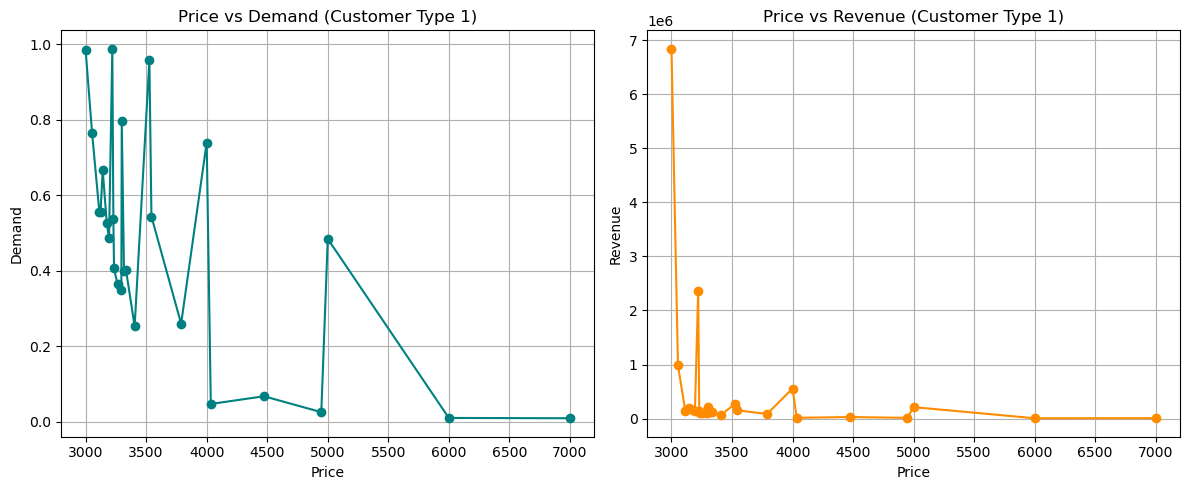

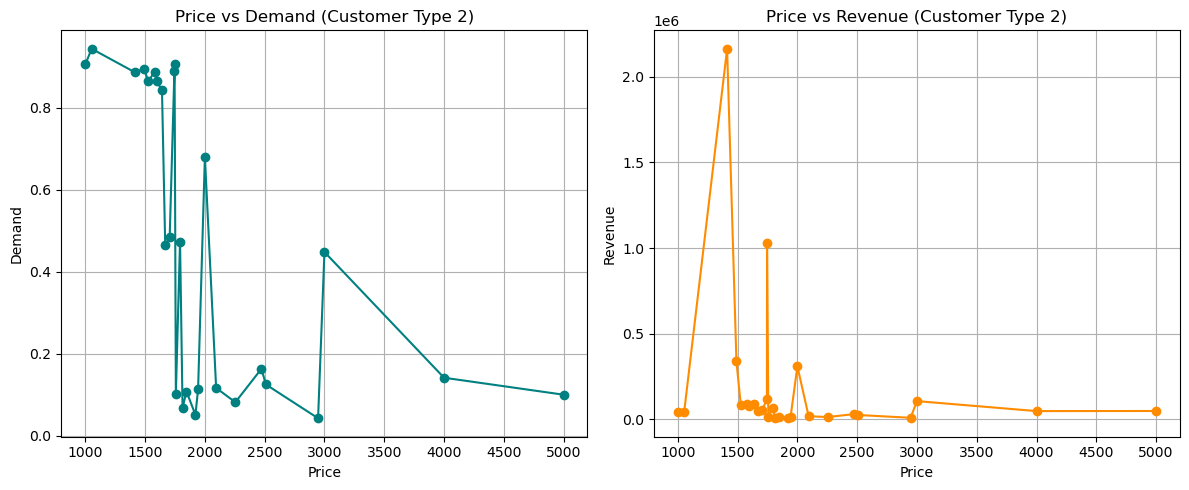

In [ ]:
# Plot results for Customer type 1 considering revenue calculation ***with considering z_opt
plot_results(df_final_results_type_1_with_z_opt)

# Plot results for Customer type 2 considering revenue calculation ***with considering z_opt
plot_results(df_final_results_type_2_with_z_opt)


### Plotting ***Price vs Demand*** and ***Price vs Revenue***:

***Without*** considering ***z_opt***, Unit value of inventory, while revenue calculation.

Calling plotting function with dataframes which have results (revenue and demand) taken without considering  z_opt.

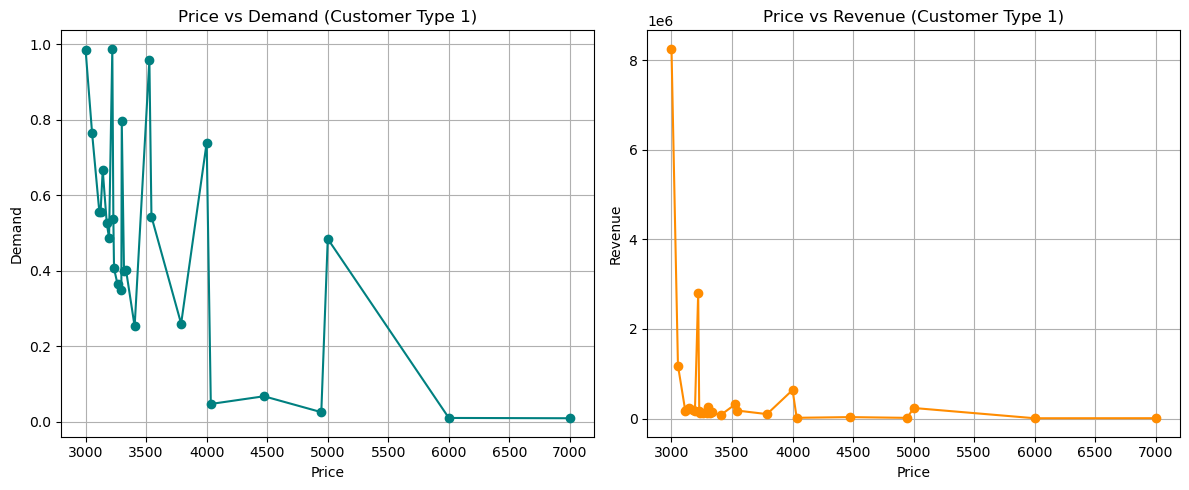

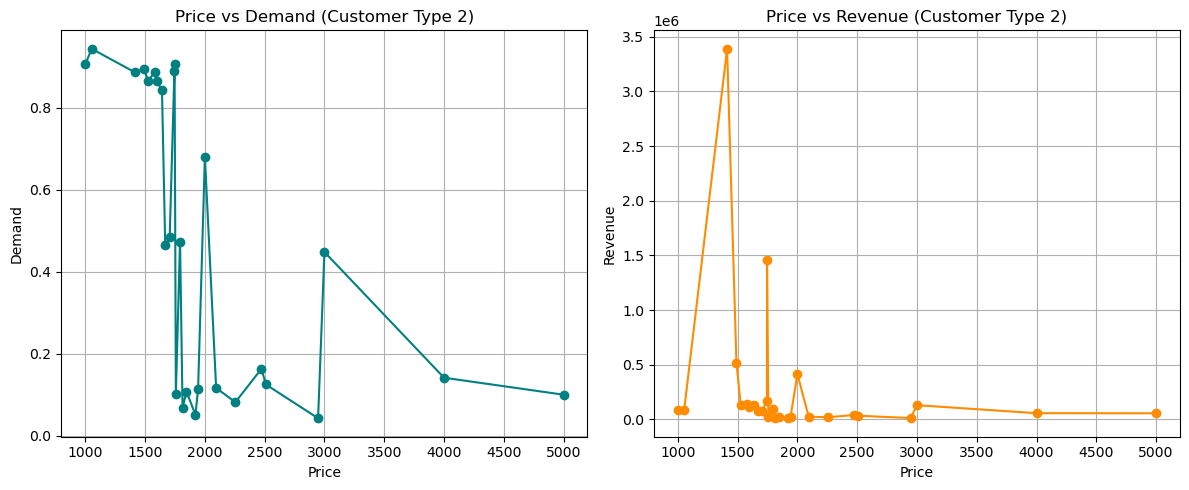

In [ ]:
# Plot results for Customer type 1 considering revenue calculation ***without considering z_opt
plot_results(df_final_results_type_1)

# Plot results for Customer type 2 considering revenue calculation ***without considering z_opt
plot_results(df_final_results_type_2)

#
#
#
#
#
#
# **END**